# Diamond Pricing Models
## Authored by Trinity Gahagen
### Phase 3 Project for Flatiron School
---
---

In [87]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 11
from matplotlib.ticker import FuncFormatter

# ML Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, make_scorer
# Regression metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

# ML Models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor

In [2]:
diamonds = pd.read_csv('updated_diamonds.csv')

In [3]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   shape       119307 non-null  object 
 1   price       119307 non-null  int64  
 2   carat       119307 non-null  float64
 3   cut         119307 non-null  object 
 4   color       119307 non-null  object 
 5   clarity     119307 non-null  object 
 6   report      119307 non-null  object 
 7   type        119307 non-null  object 
 8   sqrt_price  119307 non-null  float64
 9   log_price   119307 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 9.1+ MB


## Data Cleaning/Preprocessing

In [4]:
one_hot_columns = ['shape', 'report']

preprocessed_diamonds = pd.get_dummies(diamonds, columns=one_hot_columns, drop_first=True, dtype=int)
preprocessed_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           119307 non-null  int64  
 1   carat           119307 non-null  float64
 2   cut             119307 non-null  object 
 3   color           119307 non-null  object 
 4   clarity         119307 non-null  object 
 5   type            119307 non-null  object 
 6   sqrt_price      119307 non-null  float64
 7   log_price       119307 non-null  float64
 8   shape_Cushion   119307 non-null  int32  
 9   shape_Emerald   119307 non-null  int32  
 10  shape_Heart     119307 non-null  int32  
 11  shape_Marquise  119307 non-null  int32  
 12  shape_Oval      119307 non-null  int32  
 13  shape_Pear      119307 non-null  int32  
 14  shape_Princess  119307 non-null  int32  
 15  shape_Radiant   119307 non-null  int32  
 16  shape_Round     119307 non-null  int32  
 17  report_GIA

In [5]:
for col in ['cut', 'color', 'clarity']:
    print(diamonds[col].unique())

['Very Good' 'Ideal' 'Super Ideal' 'Good' 'Fair']
['J' 'I' 'E' 'F' 'G' 'H' 'D']
['SI2' 'SI1' 'VS2' 'VVS1' 'VS1' 'VVS2' 'IF' 'FL']


In [6]:
# Ordinal encoding for the categories with inherent order
cut_encoder = {
    'Fair' : 0,
    'Good' : 1,
    'Very Good' : 2,
    'Ideal' : 3,
    'Super Ideal': 4
}

color_encoder = {
    'J' : 0,
    'I' : 1,
    'H' : 2,
    'G' : 3,
    'F' : 4,
    'E' : 5,
    'D' : 6,
}

clarity_encoder = {
    'SI2' : 0,
    'SI1' : 1,
    'VS2' : 2,
    'VS1' : 3,
    'VVS2' : 4,
    'VVS1' : 5,
    'IF' : 6,
    'FL' : 7
}

In [7]:
preprocessed_diamonds['cut'] = preprocessed_diamonds['cut'].map(cut_encoder)

preprocessed_diamonds['color'] = preprocessed_diamonds['color'].map(color_encoder)

preprocessed_diamonds['clarity'] = preprocessed_diamonds['clarity'].map(clarity_encoder)

In [8]:
# Binarizing the type column
type_encoder = {
    'natural' : 1,
    'lab' : 0
}

In [9]:
preprocessed_diamonds['natural'] = preprocessed_diamonds['type'].map(type_encoder)

preprocessed_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           119307 non-null  int64  
 1   carat           119307 non-null  float64
 2   cut             119307 non-null  int64  
 3   color           119307 non-null  int64  
 4   clarity         119307 non-null  int64  
 5   type            119307 non-null  object 
 6   sqrt_price      119307 non-null  float64
 7   log_price       119307 non-null  float64
 8   shape_Cushion   119307 non-null  int32  
 9   shape_Emerald   119307 non-null  int32  
 10  shape_Heart     119307 non-null  int32  
 11  shape_Marquise  119307 non-null  int32  
 12  shape_Oval      119307 non-null  int32  
 13  shape_Pear      119307 non-null  int32  
 14  shape_Princess  119307 non-null  int32  
 15  shape_Radiant   119307 non-null  int32  
 16  shape_Round     119307 non-null  int32  
 17  report_GIA

In [10]:
try:
    preprocessed_diamonds.drop(columns='type', inplace=True)
except:
    print("Column already dropped")

## "Shotgun" Approach: Regression

In [11]:
initial_models = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

In [12]:
# Split data into features and target, starting with the un-transformed price column
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['price']

In [13]:
for model in initial_models:
    kfold = KFold(n_splits=10)
    regressor = initial_models[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models[model]['score'].extend(results)

In [14]:
for model in initial_models:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -250.95707663407953
----------------------------------------
Model Name: ridge
Average R^2 Score: -251.95242674416608
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -2.6165103036300836
----------------------------------------
Model Name: ada
Average R^2 Score: -544.7240159267044
----------------------------------------
Model Name: gboost
Average R^2 Score: -6.318684776194239
----------------------------------------
Model Name: knn
Average R^2 Score: -7.8380752200192045
----------------------------------------


In [15]:
# Split data into features and target, now with square root transform
# X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['sqrt_price']

initial_models_sqrt = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

In [16]:
for model in initial_models_sqrt:
    kfold = KFold(n_splits=10)
    regressor = initial_models_sqrt[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_sqrt[model]['score'].extend(results)

In [17]:
for model in initial_models_sqrt:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_sqrt[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -6.7223281993808275
----------------------------------------
Model Name: ridge
Average R^2 Score: -9.100679697885258
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.704514241817952
----------------------------------------
Model Name: ada
Average R^2 Score: -59.701916477645796
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.9645268781688676
----------------------------------------
Model Name: knn
Average R^2 Score: -4.518743036559828
----------------------------------------


In [18]:
# Split data into features and target, now with log transform
# X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

In [19]:
for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

In [20]:
for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.994353639211267
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3462632789439313
----------------------------------------
Model Name: ada
Average R^2 Score: -5.743253684801139
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6781200447564958
----------------------------------------
Model Name: knn
Average R^2 Score: -3.676155934675672
----------------------------------------


Before giving up on regression, I will remove the outliers to see if that will affect the models, since large values are severely skewing the dataset.

In [21]:
no_outliers = preprocessed_diamonds.copy()
no_outliers['zscore_price'] = (no_outliers['price'] - no_outliers['price'].mean()) / no_outliers['price'].std()
OUTLIERS = no_outliers['zscore_price'] > 3.5

X = no_outliers.loc[~OUTLIERS].drop(columns=['price', 'sqrt_price', 'log_price', 'zscore_price'])
y = no_outliers.loc[~OUTLIERS, 'log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.183705927754232
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.41324503681785
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3699855083559205
----------------------------------------
Model Name: ada
Average R^2 Score: -5.2050109522759
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.7333063938618101
----------------------------------------
Model Name: knn
Average R^2 Score: -3.74068971724384
----------------------------------------


In [22]:
OUTLIERS = no_outliers['carat'] > 5

X = no_outliers.loc[~OUTLIERS].drop(columns=['price', 'sqrt_price', 'log_price', 'zscore_price'])
y = no_outliers.loc[~OUTLIERS, 'log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}

for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.367862690519527
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.34412947938272
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3625372775028395
----------------------------------------
Model Name: ada
Average R^2 Score: -4.880789436516105
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6863557790179157
----------------------------------------
Model Name: knn
Average R^2 Score: -3.7039741757624016
----------------------------------------


Removing outliers based on price OR carats does not improve any of the models' $R^2$ scoring metric in any way. I think that I'll just start using the Gradient Boosting Regressor, since it had the only $R^2$ value that was even close to being positive.

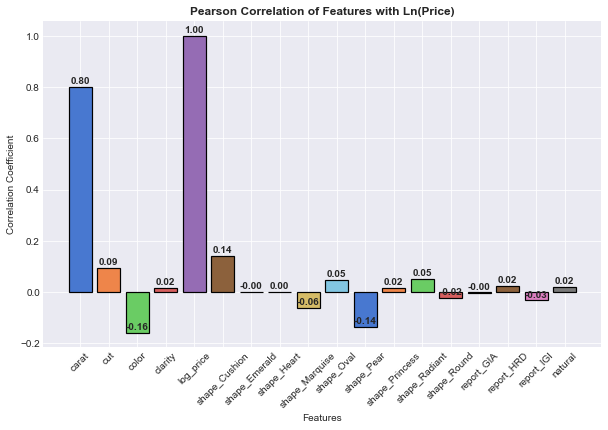

In [23]:
correlations = preprocessed_diamonds.drop(columns=['sqrt_price', 'price']).corr()['log_price']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x=correlations.index, height=correlations, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
for i in correlations.index:
    ax.annotate(f'{correlations[i]:.02f}',
                xy=(i, correlations[i] + (0.02 * ax.get_ylim()[1])),
                fontweight='bold',
                va='center',
                ha='center')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Features')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Pearson Correlation of Features with Ln(Price)');

In [24]:
selected_features = [feature for feature in correlations.index if (np.abs(correlations[feature]) >= 0.05) & (correlations[feature] < 1)]
selected_features

['carat',
 'cut',
 'color',
 'shape_Cushion',
 'shape_Marquise',
 'shape_Pear',
 'shape_Radiant']

In [25]:
X = preprocessed_diamonds[selected_features]
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models_log:
    kfold = KFold(n_splits=10)
    regressor = initial_models_log[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -6.285252883926916
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -9.5323165202889
----------------------------------------
Model Name: ada
Average R^2 Score: -7.6983779863162365
----------------------------------------
Model Name: gboost
Average R^2 Score: -7.356571992767252
----------------------------------------
Model Name: knn
Average R^2 Score: -10.729799714922363
----------------------------------------


In [26]:
# Using Min-Max Scaler
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models_log:
    kfold = KFold(n_splits=10)

    pipeline = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('regressor', initial_models_log[model]['model'])
    ])
    
    results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -6.041466643456806
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3424948588457108
----------------------------------------
Model Name: ada
Average R^2 Score: -5.683206468152657
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6781571435483489
----------------------------------------
Model Name: knn
Average R^2 Score: -4.654354747735066
----------------------------------------


In [28]:
# Using Standard Scaler
# Using Min-Max Scaler
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price'])
y = preprocessed_diamonds['log_price']

initial_models_log = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models_log:
    kfold = KFold(n_splits=10)

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', initial_models_log[model]['model'])
    ])
    
    results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1)

    initial_models_log[model]['score'].extend(results)

for model in initial_models_log:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models_log[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -20.440559782941015
----------------------------------------
Model Name: ridge
Average R^2 Score: -5.99432024735452
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -1.3330046280406425
----------------------------------------
Model Name: ada
Average R^2 Score: -5.334601507805198
----------------------------------------
Model Name: gboost
Average R^2 Score: -0.6781175175016859
----------------------------------------
Model Name: knn
Average R^2 Score: -2.8465922806167936
----------------------------------------


In [29]:
preprocessed_diamonds['price_per_carat'] = preprocessed_diamonds['price'] / preprocessed_diamonds['carat']
X = preprocessed_diamonds.drop(columns=['price', 'sqrt_price', 'log_price', 'carat', 'price_per_carat'])
y = preprocessed_diamonds['price_per_carat']

initial_models = {
    'lasso' : {
        'model' : Lasso(),
        'score' : []
    },
    'ridge' : {
        'model' : Ridge(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestRegressor(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostRegressor(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingRegressor(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsRegressor(),
        'score' : []
    }
}


for model in initial_models:
    kfold = KFold(n_splits=10)

    # pipeline = Pipeline(steps=[
    #     ('scaler', StandardScaler()),
    #     ('regressor', initial_models[model]['model'])
    # ])
    
    regressor = initial_models[model]['model']

    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models[model]['score'].extend(results)

for model in initial_models:
    print(f'Model Name: {model}')
    print(f'Average R^2 Score: {np.mean(initial_models[model]["score"])}')
    print('----------------------------------------')

Model Name: lasso
Average R^2 Score: -12.500595303335615
----------------------------------------
Model Name: ridge
Average R^2 Score: -12.418462239483171
----------------------------------------
Model Name: rand_forest
Average R^2 Score: -15.857578218112502
----------------------------------------
Model Name: ada
Average R^2 Score: -27.591094314306012
----------------------------------------
Model Name: gboost
Average R^2 Score: -13.896797778498135
----------------------------------------
Model Name: knn
Average R^2 Score: -20.74192133205866
----------------------------------------


Regression seems to produce only futile results. No matter what model I use, what transformations, features, or even outlier removal methods I include, I can't break even a 0 $R^2$ value. I'm going to pivot to Classification instead.

## "Shotgun" Approach: Classification
---


In [30]:
try:
    preprocessed_diamonds.drop(columns=['sqrt_price', 'log_price', 'price_per_carat'], inplace=True)
except:
    print("Already dropped")

preprocessed_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   price           119307 non-null  int64  
 1   carat           119307 non-null  float64
 2   cut             119307 non-null  int64  
 3   color           119307 non-null  int64  
 4   clarity         119307 non-null  int64  
 5   shape_Cushion   119307 non-null  int32  
 6   shape_Emerald   119307 non-null  int32  
 7   shape_Heart     119307 non-null  int32  
 8   shape_Marquise  119307 non-null  int32  
 9   shape_Oval      119307 non-null  int32  
 10  shape_Pear      119307 non-null  int32  
 11  shape_Princess  119307 non-null  int32  
 12  shape_Radiant   119307 non-null  int32  
 13  shape_Round     119307 non-null  int32  
 14  report_GIA      119307 non-null  int32  
 15  report_HRD      119307 non-null  int32  
 16  report_IGI      119307 non-null  int32  
 17  natural   

In [31]:
preprocessed_diamonds['price'].describe()

count    1.193070e+05
mean     3.286843e+03
std      9.114695e+03
min      2.700000e+02
25%      9.000000e+02
50%      1.770000e+03
75%      3.490000e+03
max      1.348720e+06
Name: price, dtype: float64

In [32]:
# First, create a price classification column
def price_classifier(price):
    """
    Creates classes based off of the following criteria:
    0 - Affordable
    1 - Moderately Affordable
    2 - Moderately Expensive
    3 - Expensive
    4 - Very Expensive
    """
    if 0 < price < 1000:
        return 0
    elif 1000 <= price < 3000:
        return 1
    elif 3000 <= price < 7000:
        return 2
    elif 7000 <= price < 15000:
        return 3
    else:
        return 4

In [33]:
preprocessed_diamonds['price_point'] = preprocessed_diamonds['price'].map(price_classifier)

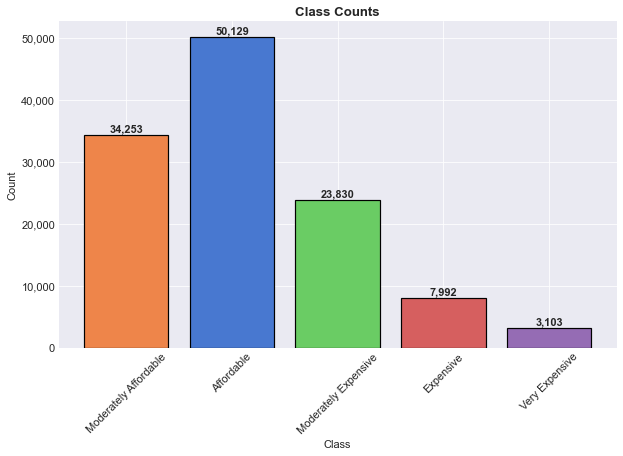

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
class_counts = preprocessed_diamonds['price_point'].value_counts()
labels = ['Affordable', 'Moderately Affordable', 'Moderately Expensive', 'Expensive', 'Very Expensive']

ax.bar(x=class_counts.index, height=class_counts, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
for i in class_counts.index:
    ax.annotate(f'{class_counts[i]:,.0f}',
                xy=(i, class_counts[i] + (0.02 * ax.get_ylim()[1])),
                fontweight='bold',
                va='center',
                ha='center')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
ax.set_xticks(class_counts.index, labels=labels)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Counts');

The counts for each class show that there is definitely an imbalance. This is worth keeping in mind for later when tuning models.

In [35]:
preprocessed_diamonds.columns

Index(['price', 'carat', 'cut', 'color', 'clarity', 'shape_Cushion',
       'shape_Emerald', 'shape_Heart', 'shape_Marquise', 'shape_Oval',
       'shape_Pear', 'shape_Princess', 'shape_Radiant', 'shape_Round',
       'report_GIA', 'report_HRD', 'report_IGI', 'natural', 'price_point'],
      dtype='object')

In [36]:
X = preprocessed_diamonds.drop(columns=['price', 'price_point'])
y = preprocessed_diamonds['price_point']

In [37]:
initial_models = {
    'logreg' : {
        'model' : LogisticRegression(),
        'score' : []
    },
    'dt' : {
        'model' : DecisionTreeClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    },
    'ada' : {
        'model' : AdaBoostClassifier(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'knn' : {
        'model' : KNeighborsClassifier(),
        'score' : []
    },
    'svm' : {
        'model' : SVC(),
        'score' : []
    }
}

for model in initial_models:
    kfold = StratifiedKFold(n_splits=10)
    regressor = initial_models[model]['model']
    
    results = cross_val_score(regressor, X, y, cv=kfold, n_jobs=-1)

    initial_models[model]['score'].extend(results)

In [38]:
for model in initial_models:
    print(f'Model Name: {model}')
    print(f'Average Accuracy Score: {np.mean(initial_models[model]["score"])}')
    print('----------------------------------------')

Model Name: logreg
Average Accuracy Score: 0.7930383625938557
----------------------------------------
Model Name: dt
Average Accuracy Score: 0.8281986327783188
----------------------------------------
Model Name: rand_forest
Average Accuracy Score: 0.8307978911712451
----------------------------------------
Model Name: ada
Average Accuracy Score: 0.6036872831859471
----------------------------------------
Model Name: gboost
Average Accuracy Score: 0.8148648750994383
----------------------------------------
Model Name: knn
Average Accuracy Score: 0.7832068038890567
----------------------------------------
Model Name: svm
Average Accuracy Score: 0.82965816788248
----------------------------------------


The best model here from just an initial look at the average accuracy score is the Random Forest Classifier.

## Tuning

Base Classifier Accuracy: 0.9344145503310703


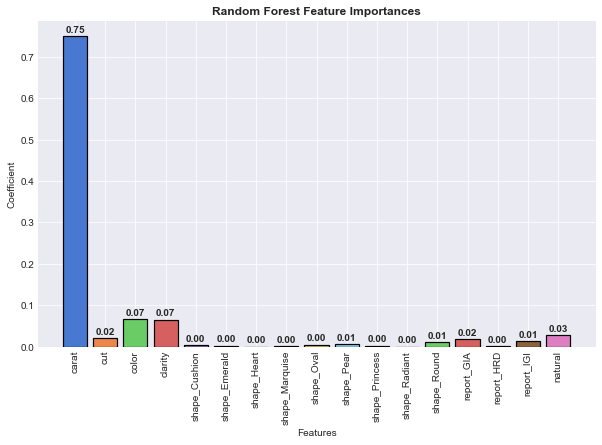

In [39]:
# Look at feature importances
X = preprocessed_diamonds.drop(columns=['price', 'price_point'])
y = preprocessed_diamonds['price_point']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


rand_forest = RandomForestClassifier()

rand_forest.fit(X_train, y_train)

feature_importances = rand_forest.feature_importances_
feature_names = X.columns
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x=feature_names, height=feature_importances, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
for i, name in enumerate(feature_names):
    ax.annotate(f'{feature_importances[i]:.02f}',
                xy=(i, feature_importances[i] + (0.02 * ax.get_ylim()[1])),
                fontweight='bold',
                va='center',
                ha='center')
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient')
ax.set_title('Random Forest Feature Importances');

print(f'Base Classifier Accuracy: {rand_forest.score(X_test, y_test)}')

To cut down on the number of features used in the model, we will only use the features with importances greater than 0.01.

In [40]:
features = ['carat', 'cut', 'color', 'clarity', 'natural', 'report_GIA']

In [41]:
X = preprocessed_diamonds[features]
y = preprocessed_diamonds['price_point']

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('rand_forest', RandomForestClassifier())
]
)

kfold = StratifiedKFold(n_splits=10)

results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1, scoring='accuracy')

In [42]:
print(f'Average Accuracy Score: {np.mean(results)}')

Average Accuracy Score: 0.8193905034979352


In [43]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rand_forest', RandomForestClassifier())
]
)

kfold = StratifiedKFold(n_splits=10)

results = cross_val_score(pipeline, X, y, cv=kfold, n_jobs=-1, scoring='accuracy')

In [44]:
print(f'Average Accuracy Score: {np.mean(results)}')

Average Accuracy Score: 0.8197006839340176


In [45]:
results = cross_val_score(RandomForestClassifier(), X, y, cv=kfold, n_jobs=-1, scoring='accuracy')
print(f'Average Accuracy Score: {np.mean(results)}')

Average Accuracy Score: 0.8195582281831062


Scaling seems to only produce a negligible difference in the average accuracy score of the model. Therefore, we will not be scaling our data.

In [46]:
param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [100, 150, 200, 300, 400, 500, 600, 700, 1000],
    'min_samples_split' : [2, 5, 10, 15, 20, 25],
    'min_samples_leaf' : [1, 2, 5, 10, 15]
}

kfold = StratifiedKFold(n_splits=10)
rand_forest = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rand_forest,
                                   param_distributions=param_grid,
                                   cv=kfold,
                                   n_iter=6,
                                   n_jobs=-1,
                                   scoring='accuracy',
                                   random_state=10)

In [47]:
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=6, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [100, 150, 200, 300, 400,
                                                      500, 600, 700, 1000],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300, 350, 400,
                                                         450, 500]},
                   random_state=10, scoring='accuracy')

In [48]:
random_search.best_estimator_

RandomForestClassifier(criterion='log_loss', max_depth=400,
                       min_samples_split=10, n_estimators=450)

In [49]:
random_search.best_score_

0.8266574357458994

In [54]:
# Trying to rebalance the classes using SMOTE
# First, by oversampling the minority classes
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')
model = RandomForestClassifier(criterion='log_loss', max_depth=400, min_samples_split=15, n_estimators=10)

steps = [('over', over), ('under', under), ('model', model)]

pipeline = imb_pipe(steps=steps)

In [56]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [58]:
print(f'Average Accuracy Score: {np.mean(scores)}')

Average Accuracy Score: 0.9141458674703754


In [84]:
X_plot = preprocessed_diamonds[['carat', 'price']]
y_plot = preprocessed_diamonds['price_point']

y_plot.value_counts()

price_point
1    50129
0    34253
2    23830
3     7992
4     3103
Name: count, dtype: int64

In [85]:
over = SMOTE(sampling_strategy='auto')

steps = [('over', over)]

test_pipe = imb_pipe(steps=steps)

X_resamp, y_resamp = test_pipe.fit_resample(X_plot, y_plot)

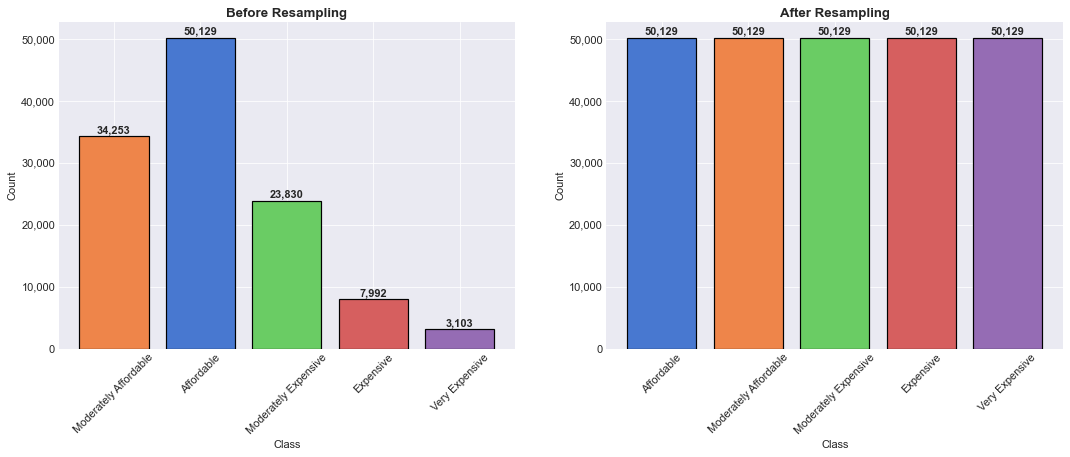

In [86]:
before_resamp = y_plot
after_resamp = y_resamp

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for n, data in enumerate([before_resamp, after_resamp]):
    ax = axes[n]
    class_counts = data.value_counts()
    labels = ['Affordable', 'Moderately Affordable', 'Moderately Expensive', 'Expensive', 'Very Expensive']

    ax.bar(x=class_counts.index, height=class_counts, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
    for i in class_counts.index:
        ax.annotate(f'{class_counts[i]:,.0f}',
                    xy=(i, class_counts[i] + (0.02 * ax.get_ylim()[1])),
                    fontweight='bold',
                    va='center',
                    ha='center')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
    ax.set_xticks(class_counts.index, labels=labels)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

axes[0].set_title('Before Resampling')
axes[1].set_title('After Resampling');
# sns.scatterplot(data=X_plot, x='carat', y='price', hue=y_plot, marker='D', alpha=0.5, edgecolor=None, ax=ax[0])
# sns.scatterplot(data=X_resamp, x='carat', y='price', hue=y_resamp, marker='D', alpha=0.5, edgecolor=None, ax=ax[1])

## FINAL MODEL: Random Forest Classifier Trained on Rebalanced Classes using Smote - 

In [ ]:
X = preprocessed_diamonds[features].drop(columns=['natural'])
y = preprocessed_diamonds['price_point']

over = SMOTE(sampling_strategy='auto')
model = RandomForestClassifier(criterion='log_loss', max_depth=400, min_samples_split=15, n_estimators=400)

steps = [('over', over), ('model', model)]

pipeline = imb_pipe(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

scores = cross_val_score(pipeline, X, y, scoring='', cv=cv, n_jobs=-1)